In [245]:
# Import needed packages
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 

# Set view options for pandas
pd.set_option('display.max_columns', 50)

# Reading in the data

The two main datasets that we will be working with are the USPTO's Cancer Moonshot Patent Data (data file available [here](https://www.uspto.gov/ip-policy/economic-research/research-datasets/cancer-moonshot-patent-data)) and the Patent Examination Research Dataset (hereafter referred to as PatEx). For the PatEx data, we are specifically using data from the 2022 release, which are available [here](https://www.uspto.gov/ip-policy/economic-research/research-datasets/patent-examination-research-dataset-public-pair)). While PatEx data is more comprehensive and attribute-rich, the Cancer Moonshot dataset is useful for my purpose because it identifies published patent applications and granted patents that are relevant to *cancer research and development*, which is the focus of this EDA project. In addition, the Moonshot dataset includes a set of fields that serve to *categorize* each invention into high-level technology categories. 

The data files that we will be using for the project are the following:

Cancer Moonshot Patent Data:
* **`Cancer Data12A.csv`**: ~270,000 patent documents spanning the 1976 to 2016 period

PatEx 2022 release:
* **`application_data.csv`**: >13 million publicly-viewable provisional and non-provisional patent applications downloaded from the Patent Examination Data System (PEDS) in June, 2023;
* **`correspondence_address.csv`**: contains name and address information of the law firm, legal department, or otherwise corresponding recipient for each application in `application_data.csv`;
* **`all_inventors.csv`**: contains the names and locations of all inventors for each application, where available.

## Cancer Moonshot Patent Data

In [2]:
# Read in data
data_moonshot = pd.read_csv('data/Cancer Data12A.csv', 
                   usecols=list(range(1,5))+list(range(12,29)),
                   parse_dates=['Filing_Date', 'Grant_or_Publication_Date', 'FDA_Approval_Date'], 
                   infer_datetime_format=True)

In [3]:
# Print shape (num. of rows, num. of columns) of dataset
print(data_moonshot.shape)
print('\n')
# Check dtypes
data_moonshot.info()

(269353, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269353 entries, 0 to 269352
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Patent_or_Publication_ID          269353 non-null  object        
 1   Application_Number                269008 non-null  object        
 2   Filing_Date                       269042 non-null  datetime64[ns]
 3   Grant_or_Publication_Date         269353 non-null  datetime64[ns]
 4   Drugs_and_Chemistry               269353 non-null  int64         
 5   Diagnostic_and_Surgical_Devices   269353 non-null  int64         
 6   Radiation_Measurement             269353 non-null  int64         
 7   Data_Science                      269353 non-null  int64         
 8   Food_and_Nutrition                269353 non-null  int64         
 9   Model_Systems_and_Animals         269353 non-null  int64         
 10  Cells_and_Enzymes

In [4]:
# Sample of the dataset
data_moonshot.sample(3)

,Patent_or_Publication_ID,Application_Number,Filing_Date,Grant_or_Publication_Date,Drugs_and_Chemistry,Diagnostic_and_Surgical_Devices,Radiation_Measurement,Data_Science,Food_and_Nutrition,Model_Systems_and_Animals,Cells_and_Enzymes,Other_and_Preclassification,DNA_RNA_or_Protein_Sequence,NIH_Federal_Grant_Number,NIH_Grant_Recipient_Organization,FDA_Application_Number,FDA_Drug_Trade_Name,FDA_Approval_Date,FDA_Applicant,FDA_Ingredient,TBD
160110,US 20090317332 A1,12/092538,2006-11-08,2009-12-24,1,1,0,0,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184160,US 7910087 B2,12/040812,2008-02-29,2011-03-22,1,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254792,US 20160159758 A1,14/933042,2015-11-05,2016-06-09,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PatEx 2022 `application_data`

In [5]:
# Grab the application numbers from Moonshot data
app_numbers = data_moonshot.Application_Number.str.replace('/', '').dropna().values
print(len(app_numbers))

269008


In [6]:
# Read in 'application_data' in chunks, filtering by app_numbers, and store in generator
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/application_data.csv', 
                 usecols=[
                     'application_number', 'filing_date','examiner_full_name', 'examiner_art_unit', 
                     'appl_status_desc', 'appl_status_date','patent_number', 'patent_issue_date'
                 ],
                 parse_dates=['filing_date', 'appl_status_date', 'patent_issue_date'],
                 infer_datetime_format=True,
                 chunksize=10000, iterator=True))

# Create new dataset by concatenating the individual chunks
data_patex = pd.concat(chunks)

In [7]:
# Print shape (num. of rows, num. of columns) of dataset
print(data_patex.shape)
print(f'{len(data_patex)/len(app_numbers)*100:.2f}% recovery')

(189282, 8)
70.36% recovery


In [8]:
# Check dtypes and other info
data_patex.dtypes

application_number            object
filing_date           datetime64[ns]
examiner_full_name            object
examiner_art_unit             object
appl_status_desc              object
appl_status_date      datetime64[ns]
patent_number                 object
patent_issue_date             object
dtype: object

In [9]:
# For some reason not all the date columns got converted to datetime when reading in the CSV
data_patex.patent_issue_date = pd.to_datetime(data_patex.patent_issue_date)

Overall, ~70% of the applications identified in the Cancer Moonshot Patent Data were "recoverable" in the PatEx 2022 release.

## Comparison of `moonshot` and `patex`

To further understand how the two datasets might be different from each other, we can look for potential differences in the number of applications available for each filing year.

The [paper](https://ssrn.com/abstract=2702637) that accompanied the first release (in 2014) of the PatEx dataset states that there is very poor coverage for applications filed prior to 1981 and limited coverage for applications received between the late 1970's and 2000 due to the fact that prior to the implementation of the American Inventors Protection Act (AIPA) in November 2000, pre-grant applications were not published. The documentation also notes that even after this date, coverage is not 100% because not all applications become publicly-viewable, typically for national security reasons.

How does this compare to the coverage in the Cancer Moonshot dataset for this same period of time?

In [10]:
# Group by number of applications filed per year
counts_moonshot = data_moonshot.groupby(data_moonshot.Filing_Date.dt.year)['Application_Number'].count()
counts_patex = data_patex.groupby(data_patex.filing_date.dt.year)['application_number'].count()

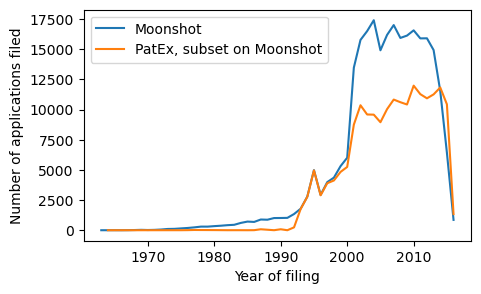

In [11]:
# Initiate figure
fig, ax = plt.subplots(figsize = (5,3))

# Plot lines
line1, = ax.plot(counts_moonshot, label='Moonshot')
line2, = ax.plot(counts_patex, label = 'PatEx, subset on Moonshot')

# Add labels
ax.legend()
ax.set_xlabel('Year of filing')
ax.set_ylabel('Number of applications filed')

plt.show()
fig.savefig('results/moonshot-patex-counts', dpi=150, format='png', bbox_inches='tight')

Compared to the `moonshot` dataset, the number of applications that could be recovered from `patex` seemed particularly low, up until the early 1990s.

The steep drop in the number of filed applications in the last few years of both datasets makes sense. The last filing date in the `moonshot` dataset is 2016-04-12. Due to the average 18-month lag for patent applications to become published, we would expect that many patent applications filed between 2014-10-12 and 2016-04-12 (an 18-month period) would not yet be published, and therefore not be present in either dataset. 

Applications filed during this period that *do* show up in the dataset are likely those that claimed the benefit of previous applications that had been filed long before.

In [12]:
data_moonshot['Filing_Date'].max() - np.timedelta64(18, 'M')

Timestamp('2014-10-12 03:16:12')

# Exploratory Data Analysis

## Outcomes of patent applications

In [13]:
patex_outcomes = data_patex[['application_number', 'appl_status_desc']].copy()

In [14]:
# Check the number of missing values
patex_outcomes.isna().sum()

# Drop rows with missing values in any column
patex_outcomes.dropna(axis=0, how='any', inplace=True)

In [15]:
import re

# Create a mapping dict
outcomes_map = {
    'abandon': 'abandoned',
    'patent': 'patented',
    'response': 'pending',
    'action': 'pending',
    'mailed': 'pending',
    'docketed': 'pending',
    'preexam': 'pending'
}
outcomes_regex = re.compile(r'(?i)(abandon|patent|response|action|mailed|docketed|preexam)')

# Create a custom function which categorizes each app and 
# assigns an outcome according to 'outcomes_map' dict
def categorize(x, default='other'):
    match = outcomes_regex.search(x)
    if match:
        return outcomes_map[match.group().lower()]
    else:
        return default

In [16]:
# Cast the column into string type
patex_outcomes['appl_status_desc'] = patex_outcomes['appl_status_desc'].astype('string')

# Apply the categorize function
patex_outcomes['outcome'] = patex_outcomes['appl_status_desc'].apply(categorize)

In [17]:
patex_outcomes.sample(5)

,application_number,appl_status_desc,outcome
8364822,14719242,Patented Case,patented
2928798,09684060,Patented Case,patented
7858378,14238511,Patented Case,patented
4334560,11053185,Patented Case,patented
3627587,10335223,Abandoned -- Failure to Respond to an Office A...,abandoned


In [18]:
# Group by outcome and status description
patex_outcomes_grouped = patex_outcomes.groupby(['outcome', 'appl_status_desc']).agg('count')

# Reset index to revert to normal index from MultiIndex
patex_outcomes_grouped.reset_index(inplace=True)

In [19]:
patex_outcomes_grouped.head()

,outcome,appl_status_desc,application_number
0,abandoned,Abandoned -- After Examiner's Answer or Board ...,1229
1,abandoned,Abandoned -- Failure to Pay Issue Fee,2232
2,abandoned,Abandoned -- Failure to Respond to an Office A...,67991
3,abandoned,Abandoned -- Incomplete Application (Pre-exami...,223
4,abandoned,Abandonment for Failure to Correct Drawings/Oa...,36


In [20]:
total = patex_outcomes['application_number'].count()
patex_outcomes['outcome'].value_counts()/total * 100

patented     60.989243
abandoned    38.674211
pending       0.237748
other         0.098798
Name: outcome, dtype: float64

The vast majority of applications are patented or abandoned. Only a very small fraction are pending, and an even smaller fraction are in 'other' (appeal processing, etc.).

## Pendency

One of the key questions that an individual or company planning to file a patent application might be interested in is: How long does will it take for the patent application to become *granted* (i.e., actually become a patent)? Of course, the major assumption here is that the application *will* eventually be granted. This is the outcome we care about, but it's worth keeping in mind that applications may also become abandoned, as we've seen above.

The time from filing an application to the grant of that application is called *total pendency*, distinguished from other forms of pendency such as *first office action pendency* (the time from filing to the issuance of a first office action). For the sake of simplicity, total pendency will just be referred to as *pendency* for the rest of the analysis.

For the Moonshot data, we have to first identify the granted patents in order to be able to calculate pendency.

In [21]:
# Convert Patent_or_Publication_ID into string type in order to apply regex pattern
data_moonshot['Patent_or_Publication_ID'].astype('string', copy = False)

# Subset only the application IDs that follow the pattern to get granted patents
pattern = r'([\w]{2}) (\d{6,8}) ([\w]{1,2})'
moonshot_granted = data_moonshot.loc[data_moonshot['Patent_or_Publication_ID'].str.match(pattern),
                                    ['Application_Number', 
                                     'Filing_Date', 
                                     'Grant_or_Publication_Date']]

# Print shape of granted data
print(f'There are {moonshot_granted.shape[0]} granted patents in the Moonshot data')

There are 111148 granted patents in the Moonshot data


In [22]:
# Function to calculate the pendency, add as a new column in df, 
# and drop rows for which pendency is NaN
def pendency(df_in, issue_col, filing_col):
    df_out = df_in.copy()
    df_out['pendency'] = (df_out[issue_col]-df_out[filing_col]) / np.timedelta64(1, 'M')
    df_out.dropna(subset='pendency', inplace=True)
    return df_out

In [23]:
# Apply the function to get pendency in both datasets
moonshot_granted = pendency(moonshot_granted, 'Grant_or_Publication_Date', 'Filing_Date')
patex_granted = pendency(data_patex, 'patent_issue_date', 'filing_date')

Let's create some line plots showing filing date on the x-axis and pendency on the y-axis, just to get an initial impression of how pendency has changed over time.

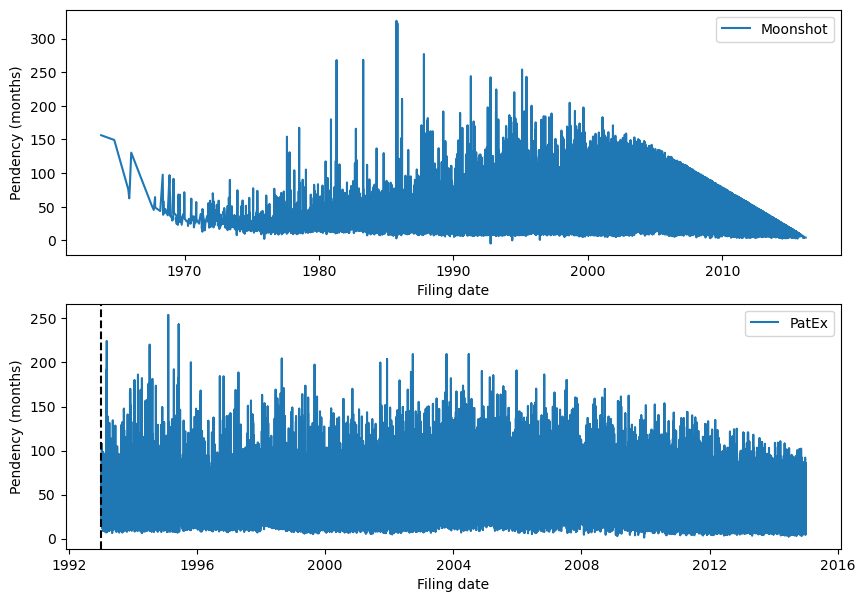

In [115]:
# Initialize figure and axes
fig, axs = plt.subplots(nrows=2, figsize=(10,7))

# Plot line plots
axs[0].plot(moonshot_granted.sort_values(by='Filing_Date')['Filing_Date'], 
            moonshot_granted.sort_values(by='Filing_Date')['pendency'], 
            label='Moonshot')
axs[1].plot(patex_granted.sort_values(by='filing_date')['filing_date'], 
            patex_granted.sort_values(by='filing_date')['pendency'], 
            label='PatEx')

# Add axis labels and legend
for ax in axs:
    ax.set_xlabel('Filing date')
    ax.set_ylabel('Pendency (months)')
    ax.legend()
    
# Add annotation
date = np.datetime64('1993-01-01')
axs[1].axvline(x=date, ls='dashed', color='black')

plt.show()
fig.savefig('results/moonshot-patex-pendency', dpi=150, format='png', bbox_inches='tight')

There's a lot of variation in the graphs above and it's hard to tell clearly how pendency changes over time. 

There's also clearly incomplete coverage in the early decades (1970s, 1980s) for both datasets. Comparatively, `Moonshot` has more coverage for these decades than `PatEx`. This corroborates what we already saw earlier.

In [25]:
patex_granted.groupby(patex_granted['filing_date'].dt.year).application_number.count()

filing_date
1964       1
1969       1
1975       2
1976       8
1977      21
1978      17
1980      12
1982       2
1983       3
1984       3
1985       1
1986       5
1987      80
1989       3
1990      80
1991       1
1992     237
1993    1764
1994    2768
1995    4944
1996    2891
1997    3860
1998    3988
1999    4608
2000    4960
2001    5321
2002    5400
2003    4711
2004    4577
2005    4264
2006    4660
2007    5270
2008    5150
2009    5380
2010    6467
2011    6324
2012    6514
2013    6736
2014    7289
2015    6690
2016     838
Name: application_number, dtype: int64

In the `PatEx` dataset, we can see that there was a big jump in the number of apps filed going from 1992 to 1993. We have to accept that, by using the `PatEx` data, we're going to get poorer coverage before 1993 in exchange for more updated information for apps filed more recently (2000s-2010s).

Given the 18-month publication lag discussed above, it also makes sense to limit the `patex` dataset to applications filed before 2015.  

In [26]:
# Subset PatEx granted df for apps filed after 1993 and before 2015
patex_granted = patex_granted.loc[(patex_granted['filing_date'] > '1993')
                                 & (patex_granted['filing_date'] < '2015')].copy()

In [27]:
# Check that the data has been correctly subset
print(f"Earliest filing date: {patex_granted['filing_date'].min()}, "
      f"Latest filing date: {patex_granted['filing_date'].max()}")

Earliest filing date: 1993-01-04 00:00:00, Latest filing date: 2014-12-31 00:00:00


### Distribution of pendency
We can plot the pendency as a distribution to visualize the spread of the data.

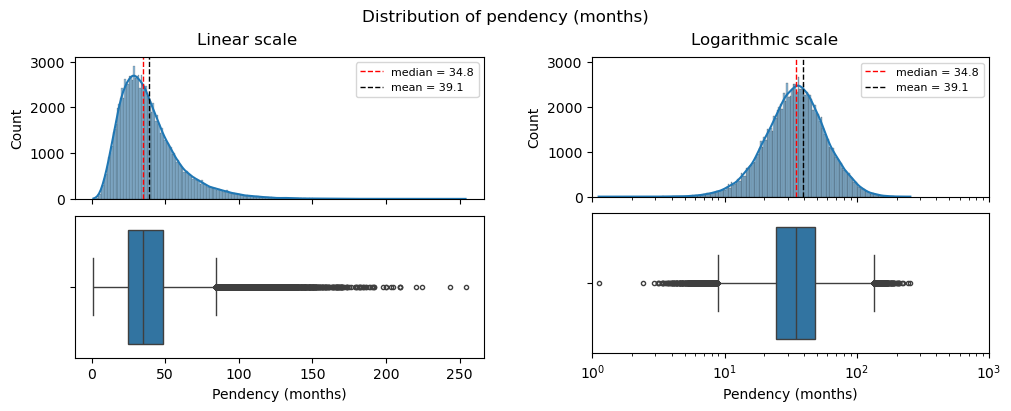

In [116]:
# Initialize fig, subfig, and axes
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(ncols=2, wspace=0.07)
axsLeft = subfigs[0].subplots(nrows=2, sharex=True)
axsRight = subfigs[1].subplots(nrows=2, sharex=True)

# Create plots
sns.histplot(data=patex_granted, x='pendency', kde=True, ax=axsLeft[0])
sns.boxplot(data=patex_granted, x='pendency', fliersize=3, ax=axsLeft[1])
sns.histplot(data=patex_granted, x='pendency', kde=True, log_scale=True, ax=axsRight[0])
sns.boxplot(data=patex_granted, x='pendency', fliersize=3, log_scale=True, ax=axsRight[1])

# Set labels and titles
for ax in axsLeft:
    ax.set_xlabel('Pendency (months)')
for ax in axsRight:
    ax.set_xlabel('Pendency (months)')
subfigs[0].suptitle('Linear scale')
subfigs[1].suptitle('Logarithmic scale')
fig.suptitle('Distribution of pendency (months)', fontsize='large')

# Add annotations and legends to show mean, median
for ax in axsLeft[0], axsRight[0]:
    ax.axvline(patex_granted['pendency'].median(), color='red', ls='dashed', lw=1, 
               label=f'median = {patex_granted["pendency"].median():.1f}')
    ax.axvline(patex_granted['pendency'].mean(), color='black', ls='dashed', lw=1, 
               label=f'mean = {patex_granted["pendency"].mean():.1f}')
    ax.legend(fontsize=8)
    # Adjust the ylims
    ax.set_ylim(0, 3100)
    
# Adjust xlim for lognormal graphs
for ax in axsRight:
    ax.set_xlim(1, 1000)
    
plt.show()
fig.savefig('results/patex-granted-distribution', dpi=150, format='png', bbox_inches='tight')

In [29]:
# Get some summary stats
patex_granted['pendency'].describe()

count    107846.000000
mean         39.115449
std          21.026931
min           1.117066
25%          24.575453
50%          34.760467
75%          48.493809
max         254.099674
Name: pendency, dtype: float64

### Change in median pendency over time

To help see how pendency changes over time, we can plot the median pendency over the different filing years.

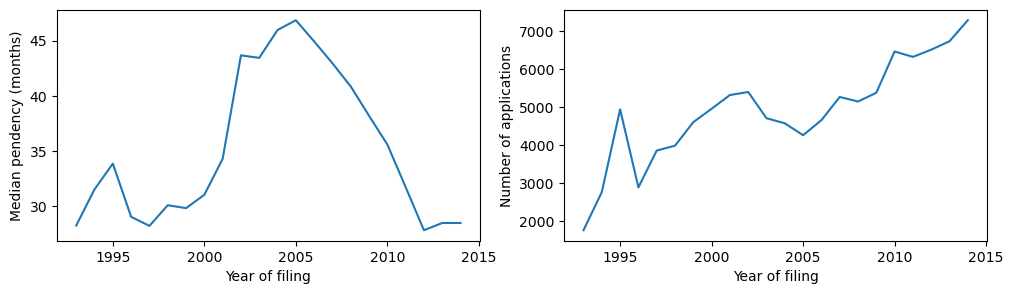

In [117]:
# Get data
median_pendency = patex_granted.groupby(patex_granted['filing_date'].dt.year)['pendency'].median()
appls_filed = patex_granted.groupby(patex_granted['filing_date'].dt.year)['application_number'].count()

# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)

# Plot line plots
ax1.plot(median_pendency)
ax2.plot(appls_filed)

# Add labels
for ax in (ax1, ax2):
    ax.set_xlabel('Year of filing')
ax1.set_ylabel('Median pendency (months)')
ax2.set_ylabel('Number of applications')

plt.show()
fig.savefig('results/patex-pendency-vs-filing-year', dpi=150, format='png', bbox_inches='tight')

### Effect of patent category on pendency

We can also look at the distribution of pendency for the different categories, to see if there's any difference in pendency between categories.

Now's the time we need to merge `patex_granted` with our `Moonshot` data to get the categories.

The `Moonshot` data is currently in a "wide" format (one row for each patent application). Let's reshape it to a "stacked" or "long" format so that data about the different patent categories are in the same column.

In [31]:
# Remove the slashes in 'Application_Number' for easy merging later
data_moonshot['Application_Number'] = data_moonshot['Application_Number'].str.replace('/','')

In [32]:
# Subset the data to only application number, filing date and categories
cat_moonshot = data_moonshot.loc[:, ['Application_Number', 'Filing_Date', *data_moonshot.columns[4:13]]]

In [33]:
# Replace the 1s in the category columns with the category names
cat_moonshot = cat_moonshot.replace(to_replace=1, 
                                    value=dict(zip(cat_moonshot.columns[2:], cat_moonshot.columns[2:])))

# Transform to long format
cat_moonshot = pd.melt(
    cat_moonshot, 
    id_vars=list(cat_moonshot.columns[:2]),
    value_vars=list(cat_moonshot.columns[2:]), 
    value_name='category'
)

# Drop the variable column
cat_moonshot.drop('variable', axis=1, inplace=True)

# Drop rows that have a 0 in new 'category' column
cat_moonshot = cat_moonshot.loc[cat_moonshot['category'] != 0]

In [34]:
cat_moonshot.sample()

,Application_Number,Filing_Date,category
2397207,12396605,2009-03-03,DNA_RNA_or_Protein_Sequence


In [35]:
# Merge with 'patex_granted' and drop unneeded columns
patex_granted_cat = pd.merge(patex_granted, cat_moonshot, 
                             how='left', left_on='application_number', 
                             right_on='Application_Number').drop(['Application_Number', 'Filing_Date'], axis=1)

Now we can answer the question: Does pendency vs. filing date differ between different categories of patents?

We can visualize the data using box-and-whisker (box) and violin plots.

In [36]:
patex_granted_cat.head(5)

,application_number,filing_date,examiner_full_name,examiner_art_unit,appl_status_desc,appl_status_date,patent_number,patent_issue_date,pendency,category
0,07961924,1993-01-04,"BOND, ROBERT",1202,Patented Case,1994-04-28,5310900,1994-05-10,16.131748,Drugs_and_Chemistry
1,08000158,1993-01-04,"WANG, GIAN",1812,Patented Case,1994-03-04,5294700,1994-03-15,14.291875,Drugs_and_Chemistry
2,08000931,1993-01-05,"GRIMES, ERIC BURTON",1814,Patent Expired Due to NonPayment of Maintenanc...,2018-01-26,5578477,1996-11-26,46.686790,Cells_and_Enzymes
3,07960405,1993-01-06,"GOLDBERG, JEROME D",1205,Patent Expired Due to NonPayment of Maintenanc...,2018-01-26,5439921,1995-08-08,31.015011,Drugs_and_Chemistry
4,08001010,1993-01-06,"TILL, MARY C",1209,Patent Expired Due to NonPayment of Maintenanc...,2006-10-12,5346895,1994-09-13,20.205754,Drugs_and_Chemistry


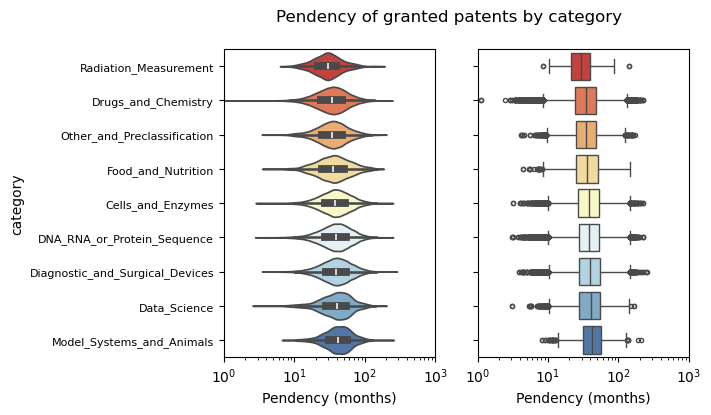

In [118]:
# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,4), sharey=True)

# Setting the order by increasing median
order = patex_granted_cat.groupby('category')['pendency'].mean().sort_values().index

# Create plots
sns.violinplot(patex_granted_cat, x='pendency', y='category', order=order, 
               hue='category', hue_order=order, palette='RdYlBu', log_scale=True, 
               ax=ax1)
sns.boxplot(patex_granted_cat, x='pendency', y='category', order=order,
            hue='category', hue_order=order, palette='RdYlBu', fliersize=3, 
            log_scale=True, ax=ax2)

# Add plot titles and axis labels
for ax in (ax1, ax2):
    ax.set_xlabel('Pendency (months)')
    ax.set_xlim(1, 1000)
    # Show only outer y label
    ax.label_outer()
ax1.tick_params(axis='y', labelsize=8)
fig.suptitle('Pendency of granted patents by category')

plt.show()
fig.savefig('results/pendency-by-category', dpi=150, format='png', bbox_inches='tight')

We can alternatively visualize the data using a line plot, focusing on median pendency:

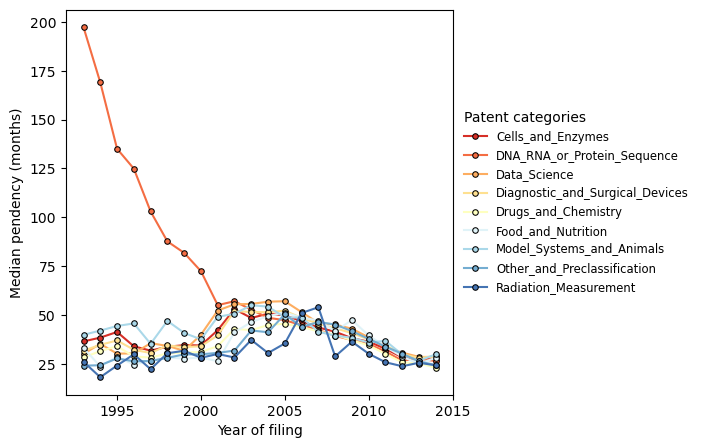

In [119]:
fig, ax = plt.subplots(figsize=(5,5))

# Group data by category and filing year 
data = (patex_granted_cat
        .groupby(['category', patex_granted_cat['filing_date'].dt.year])[['pendency']]
        .median()
)

# Assign the categories to a list for marker assignment
categories = data.index.get_level_values(0).unique()

# Plot line plot
prop_kwargs = dict(
    palette='RdYlBu', 
    style='category', 
    dashes=False,
    markers=dict(zip(categories, ['o']*len(categories))), 
    markeredgecolor='black', 
    markersize=4
)
sns.lineplot(data=data, x='filing_date', y='pendency', 
             hue='category', ax=ax, **prop_kwargs)

# Add labels and adjust legend
ax.set_xlabel('Year of filing')
ax.set_ylabel('Median pendency (months)')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), 
          fontsize='small', title='Patent categories', 
          alignment='left', frameon=False)

plt.show()
fig.savefig('results/pendency-by-category-by-year', dpi=150, format='png', bbox_inches='tight')

### Examiner effect on pendency

Question: Are there differences between examiners in terms of pendency?

In [53]:
# Remove rows with NaNs in examiner name
examiner_df = patex_granted.loc[~patex_granted['examiner_full_name'].isna()].copy()

In [54]:
# Check the number of NaNs
examiner_df.isna().sum()

application_number    0
filing_date           0
examiner_full_name    0
examiner_art_unit     0
appl_status_desc      0
appl_status_date      0
patent_number         0
patent_issue_date     0
pendency              0
dtype: int64

As a way to compare between examiners, we can compare the mean pendency (with 95% CI) of the fastest and slowest examiners. 

In [55]:
# Write custom function that does the analysis below
def examiner_calc(df_in, cutoff=None):
    '''This function takes the examiner dataframe with pendency
    data (optionally subset by a cutoff filing year) and returns the
    following pendency stats for each examiner: mean, standard
    deviation, count (number of apps examined), and the SEM.
    It also calculates the boundary values for the 95% CI of
    the mean as well as the half-width of the 95% CI for 
    easier plotting down the road.
    '''
    # Subset by chosen cutoff year if provided
    if cutoff:
        df_copy = df_in.loc[df_in.filing_date.dt.year > cutoff].copy()
    else:
        df_copy = df_in.copy()

    # Group by examiner name and get some stats for pendency per examiner
    df_copy = df_copy.groupby('examiner_full_name')['pendency'].agg(['mean', 'std', 'count', 'sem'])
    # Remove examiners with fewer than 5 applications
    df_copy = df_copy.loc[df_copy['count'] >= 5].reset_index()

    # Calculate 95% CI boundary values
    nums = zip(df_copy['mean'], df_copy['count'], df_copy['sem'])
    ci = map(lambda x: stats.t.interval(confidence=0.95, df=x[1]-1, loc=x[0], scale=x[2]), nums)
    lower, upper = list(zip(*ci))  # Unzip T to get all the lower bounds and upper bounds together
    
    # Combine with ex_stats
    new_cols = pd.DataFrame({'lower': lower, 'upper': upper})
    df_copy = pd.concat([df_copy, new_cols], axis=1)
    
    # Get the half-width (margin error) of the 95% CI for easier plotting later
    df_copy['meCI'] = df_copy['mean']-df_copy['lower']
    
    # Create df with fastest examiners
    fastest = df_copy.sort_values(by='mean', ascending=False).tail(10).copy()
    # Create df with slowest examiners
    slowest = df_copy.sort_values(by='mean', ascending=False).head(10).copy()
    
    return df_copy, fastest, slowest

In [56]:
# Run function without applying a cutoff year 
examiner_stats, fastest, slowest = examiner_calc(examiner_df)

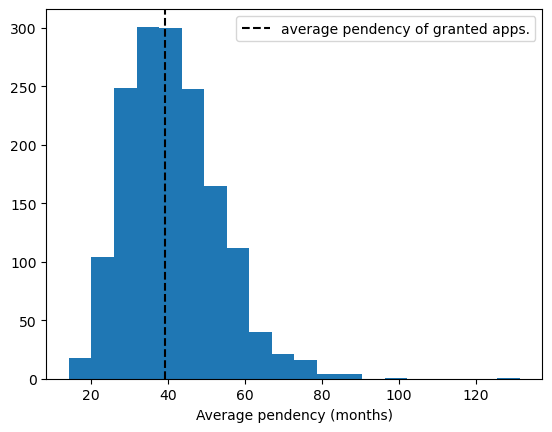

In [57]:
# Quick plot to show distribution of average pendency amongst examiners
plt.hist(examiner_stats['mean'], bins=20)
plt.xlabel('Average pendency (months)')
plt.axvline(patex_granted['pendency'].mean(), color='black', linestyle='dashed', 
            label='average pendency of granted apps.')
plt.legend()

In [58]:
examiner_stats.describe()

,mean,std,count,sem,lower,upper,meCI
count,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,41.227586,17.857766,66.123737,3.763234,32.713756,49.741415,8.513829
std,12.170904,7.350220,97.866566,2.729258,10.456054,16.897775,7.021470
min,14.226165,2.813211,5.000000,0.492058,-0.578267,17.068019,0.966965
25%,32.337284,12.274846,10.000000,1.842924,24.847743,37.541728,3.760208
50%,39.830764,17.288360,26.000000,2.949372,32.498777,46.971831,6.146362
75%,48.319952,22.338040,75.250000,4.997611,39.908295,57.991413,11.040192
max,131.337399,48.843969,761.000000,19.176594,82.042396,180.632402,51.592968


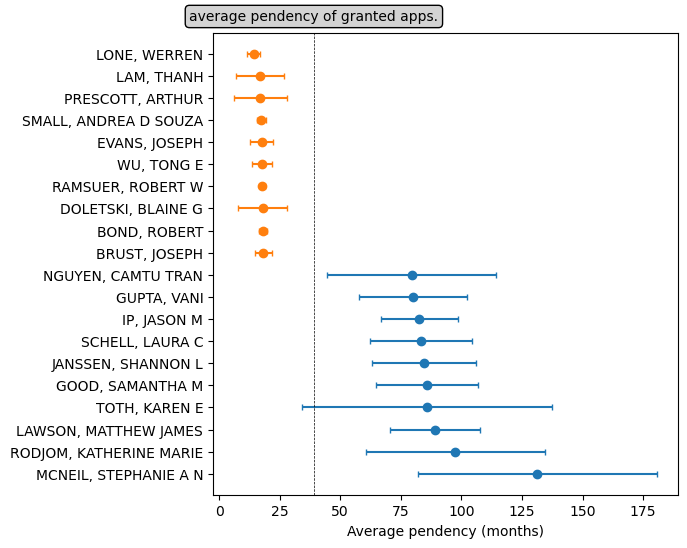

In [129]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(6,6))

# Plot the average pendency with 95% CI for the slowest and fastest examiners
for data in slowest, fastest:
    ax.errorbar(data=data, x='mean',y='examiner_full_name', xerr='meCI', fmt='o', capsize=2)

# Add a vertical line to indicate the average pendency of granted apps
ax.axvline(patex_granted['pendency'].mean(), color='black', linestyle='dashed', linewidth='0.5')

# Annotate the line
ax.text(x=patex_granted['pendency'].mean(), y=1.02, 
        s='average pendency of granted apps.', 
        ha='center', va='bottom', 
        bbox=dict(boxstyle='round', fc='lightgray'), 
        transform=ax.get_xaxis_transform())

# Add labels
ax.set_xlabel('Average pendency (months)')

plt.show()
fig.savefig('results/slowest-fastest-examiners', dpi=150, format='png', bbox_inches='tight')

Can the average pendency for an examiner tell us anything about how "easy" or "difficult" that particular examiner is? A potential way of determing the 'difficulty' of an examiner is to calculate the ratio of allowed vs. abandoned cases for each examiner (possibly within a specified timeframe), e.g., a 'grant rate'. This is the methodology that [PatentBots](https://www.patentbots.com/stats/) uses to assign a 'difficulty' ranking to examiners in its database. How does an examiner's average pendency time correlate with PatentBot's difficulty ranking? 

In [60]:
# To align more closely with PatentBot's methodology,
# let's look at data from more recent patent applications filed after 2010
recent_examiner_stats, recent_fastest, recent_slowest = examiner_calc(examiner_df, cutoff=2010)

In [61]:
recent_examiner_stats.head()

,examiner_full_name,mean,std,count,sem,lower,upper,meCI
0,"ABDI, AMARA",28.663148,10.601349,12,3.060346,21.927373,35.398924,6.735776
1,"ABOUELELA, MAY A",42.985140,26.169333,9,8.723111,22.869610,63.100670,20.115530
2,"ADZAMLI, KOFI",28.006442,12.225179,7,4.620683,16.700037,39.312847,11.306405
3,"AEDER, SEAN E",33.880340,16.807533,137,1.435964,31.040633,36.720047,2.839707
4,"AFREMOVA, VERA",50.780509,32.801983,5,14.669493,10.051468,91.509550,40.729041


#### Random sampling of examiners
A random sample of 25 examiners was generated and exported to a CSV file. From there, the CSV file was updated with the PatentBot ranking for each examiner, where available, by manually looking up the examiner in PatentBots.

In [62]:
# Load updated csv with PatentBot ranking
random_sample = pd.read_csv('data/random_sample_examiners.csv', usecols=[1,2,3], na_values='None')
random_sample = random_sample.dropna(axis=0)

What is the relationship between PatentBot ranking and average pendency of examiners? We can look at the correlation between an examiner's PatentBots rank and their average pendency.

In [63]:
# Calculate Pearson's correlation coefficient
ranking = random_sample['patent_bots_rank'].to_numpy()
mean = random_sample['mean'].to_numpy()
stats.pearsonr(ranking, mean)

PearsonRResult(statistic=0.5627816794248822, pvalue=0.009784569571179324)

We can also try to fit a linear regression model to the data:

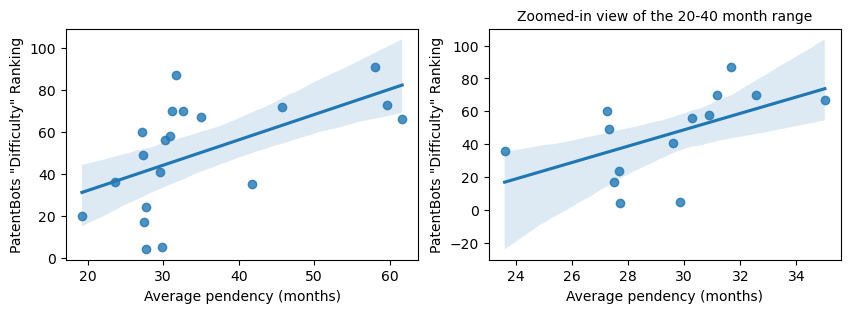

In [133]:
# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

# Plot regression plot
sns.regplot(data=random_sample, x='mean', y='patent_bots_rank', ax=ax1)
# 'Zoom in' on the regression over a subset of the data
subset = random_sample[(random_sample['mean'] > 20) & (random_sample['mean'] < 40)]
sns.regplot(data=subset, x='mean', y='patent_bots_rank', ax=ax2)

# Add labels
for ax in (ax1, ax2):
    ax.set_ylabel('PatentBots "Difficulty" Ranking')
    ax.set_xlabel('Average pendency (months)')
ax2.set_title(f'Zoomed-in view of the 20-40 month range', fontsize='medium')
    
plt.show()

#### Stratified sampling of examiners
Another way of sampling is by binning the data (e.g., into quartiles) and randomly selecting *n* samples from each quartile (stratified sampling).

In [65]:
# Bin data into quartiles and assign a label to each data point 
# in a new column indicating quartile membership
recent_examiner_stats['quartile'] = pd.qcut(recent_examiner_stats['mean'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Sample from each quartile
q1 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q1'].sample(10, random_state=8)
q2 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q2'].sample(10, random_state=8)
q3 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q3'].sample(10, random_state=8)
q4 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q4'].sample(10, random_state=8)

# Concatenate all the samples and export
stratified_sample = pd.concat([q1, q2, q3, q4])
# stratified_sample.to_csv('stratified_sample.csv', index=False)

In [66]:
# Load updated csv with PatentBot ranking
stratified_sample = pd.read_csv('data/stratified_sample_examiners.csv', usecols=[0,1,9], na_values='None')

# Drop NaN values
stratified_sample = stratified_sample.dropna(axis=0)

In [67]:
# Calculate the Pearson correlation coefficient
s_ranking = stratified_sample['patent_bots_rank'].to_numpy()
s_mean = stratified_sample['mean'].to_numpy()
stats.pearsonr(s_ranking, s_mean)

PearsonRResult(statistic=0.6500841154365138, pvalue=0.0005846345475010717)

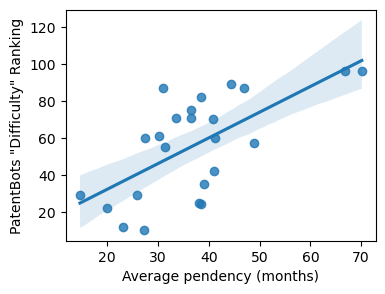

In [134]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Plot regression plot for stratified samples
sns.regplot(data=stratified_sample, x='mean', y='patent_bots_rank', ax=ax)

# Add labels, adjust ylim
ax.set_ylabel('PatentBots "Difficulty" Ranking')
ax.set_xlabel('Average pendency (months)')

plt.show()

#### Pooled samples of examiners
We can pool all the data that we've randomly sampled, and calculate the Pearson *r* and plot a regression line for this pooled data.

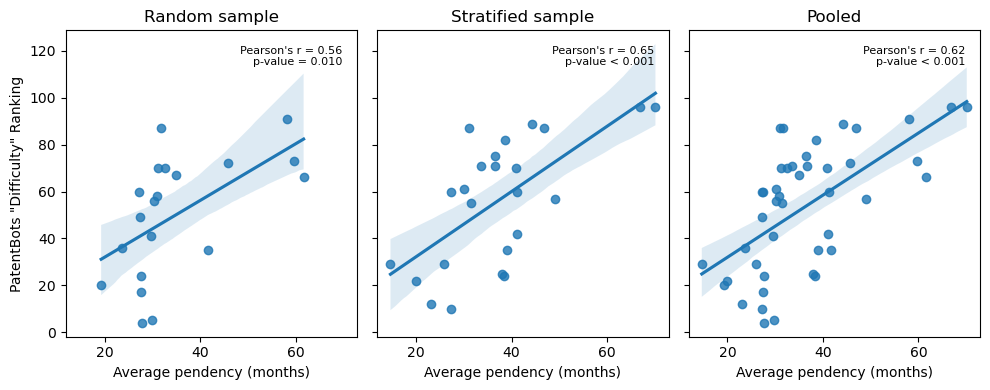

In [135]:
# Pool all the data
combined = pd.concat([random_sample, stratified_sample], axis=0)
data = [random_sample, stratified_sample, combined]

# Calculate Pearson correlation coefficients
def pearsons(data_list):
    coeffs = []
    for data in data_list:
        ranking = data['patent_bots_rank'].to_numpy()
        mean = data['mean'].to_numpy()
        coeff = stats.pearsonr(ranking, mean)
        coeffs.append(coeff)
    return coeffs

# Initialize figure
fig, axs = plt.subplots(ncols=3, figsize=(10, 4), sharey=True, sharex=True, layout='tight')

# Plot regression lines
for d, a in zip(data, axs):
    sns.regplot(data=d, x='mean', y='patent_bots_rank', ax=a)
    a.label_outer()
    a.set_xlabel('Average pendency (months)')

# Add labels
axs[0].set_ylabel('PatentBots "Difficulty" Ranking')
axs[0].set_title('Random sample')
axs[1].set_title('Stratified sample')
axs[2].set_title('Pooled')

# Add Pearson's coefficient and p-values
coeffs = pearsons(data)
for d, a, p in zip(data, axs, coeffs):
    if p[1] > 0.001:
        a.text(0.95, 0.95, f"Pearson's r = {p[0]:.2f}\np-value = {p[1]:.3f}", 
               transform=a.transAxes, fontsize=8, ha='right', va='top')
    else:
        a.text(0.95, 0.95, f"Pearson's r = {p[0]:.2f}\np-value < 0.001", 
               transform=a.transAxes, fontsize=8, ha='right', va='top')

plt.show()
fig.savefig('results/examiner-samples-linreg', dpi=150, format='png', bbox_inches='tight')

### Effect of company size or law firm on pendency

Question: Does the size of a company or the law firm that is representing the company in the filing affect pendency?

Correspondence data is stored in a CSV file called `correspondence_address` as part of the PatEx 2022 release. In most cases the entity is a law firm or the legal department of a commercial enterprise.

In [70]:
app_numbers = patex_granted['application_number'].values

In [71]:
# Read in correspondence_address in chunks and store filtered chunks in a generator called chunks
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/correspondence_address.csv', 
                 usecols = ['application_number','correspondence_name'],
                 dtype = {'correspondence_name':'string'}, chunksize = 10000, iterator=True))

# Create new dataframe by concatenating the individual chunks
patex_corres = pd.concat(chunks)

In [72]:
# Drop rows for which 'correspondence_name' is NaN
patex_corres = patex_corres.loc[~patex_corres['correspondence_name'].isna()].copy()

Source for list of largest biotech/pharma companies [here](https://companiesmarketcap.com/biotech/largest-companies-by-market-cap/).

In [73]:
# Regex patterns for biotech company names
biotech_patterns = '|'.join((
    'Eli\sLilly','Novo\sNordisk','J[ohnson]*\s*&\s*J[ohnson]*','Novo\sNordisk','AbbVie','Merck',
    '\bRoche\b','Novartis','A[stra]*Z[eneca]*','Thermo\s*Fisher\s*Scientific','Pfizer','Amgen','Sanofi',
    'B[ristol]*[-\s]*M[yers]*\s*S[quibb]*','Gilead','Vertex','Regeneron','Zoetis','CSL',
    'G[laxo]*\s*S[mith]*\s*K[line]*','Daiichi'))

In [74]:
biotech_patterns

'Eli\\sLilly|Novo\\sNordisk|J[ohnson]*\\s*&\\s*J[ohnson]*|Novo\\sNordisk|AbbVie|Merck|\x08Roche\x08|Novartis|A[stra]*Z[eneca]*|Thermo\\s*Fisher\\s*Scientific|Pfizer|Amgen|Sanofi|B[ristol]*[-\\s]*M[yers]*\\s*S[quibb]*|Gilead|Vertex|Regeneron|Zoetis|CSL|G[laxo]*\\s*S[mith]*\\s*K[line]*|Daiichi'

In [75]:
# Test if 'correspondence_name' contains a match to biotech_patterns and output result to new column
patex_corres['large_biotech'] = patex_corres['correspondence_name'].str.contains(biotech_patterns, case=False)

Source for rankings of life sciences law firms [here](https://chambers.com/legal-rankings/life-sciences-usa-nationwide-5:376:12788:1).

In [76]:
# Create firm regex patterns
firm_patterns = '|'.join(['Cooley','Covington','Goodwin','Latham & Watkins','WilmerHale','Ropes & Gray','Sidley','Wilson Sonsini',
                          'A[rnold]*\s*&\s*P[orter]*','Gibson[,\s]*Dunn','Hogan Lovells','K[irkland]*\s*&\s*E[llis]*',
                          'Mo[rrison]*\s?&?\s?Fo[erster]*','Dechert','\bDLA\b','Fenwick','Jones Day','McDermott','Mintz',
                          'Morgan[\s,]*Lewis','Quinn Emanuel','\bWeil\b[\S]+','W[hite]*\s*&\s*C[ase]*','(?<!Morgan & )\bFinnegan\b',
                          '(?<!Morgan and )\bFinnegan\b','\\bBaker\\b\\s+Botts','\bBaker\b\s+[&\s]*Mckenzie','^Choate',
                          'Cravath','Greenberg Traurig','Hastings','Venable','Rakoczy'])

In [77]:
# Test if 'correspondence_name' contains a match to firm_patterns and output result to new column
patex_corres['large_firm'] = patex_corres['correspondence_name'].str.contains(firm_patterns, case=False)

In [78]:
patex_corres.head(10)

,application_number,correspondence_name,large_biotech,large_firm
1519092,07961924,MORGAN & FINNEGAN,False,False
1519185,08000158,Pfizer Inc.,True,False
1519848,08000931,Crowell/BGL,False,False
1519862,07960405,NIXON & VANDERHYE,False,False
1519953,08001010,GABOR L. SZEKERES,False,False
1519954,08001009,GABOR L. SZEKERES,False,False
1520055,08001136,NOVARTIS PHARMACEUTICAL CORPORATION,True,False
1520079,08001229,"OBLON, MCCLELLAND, MAIER & NEUSTADT, L.L.P.",False,False
1520169,08001564,BIERMAN AND MUSERLIAN,False,False
1520261,07960389,EDWIN P. CHING,False,False


In [79]:
# Grab 'pendency' data from 'patex_granted' and merge
patex_corres = patex_corres.merge(patex_granted[['application_number', 'pendency']], 
                                  how='left', on='application_number')

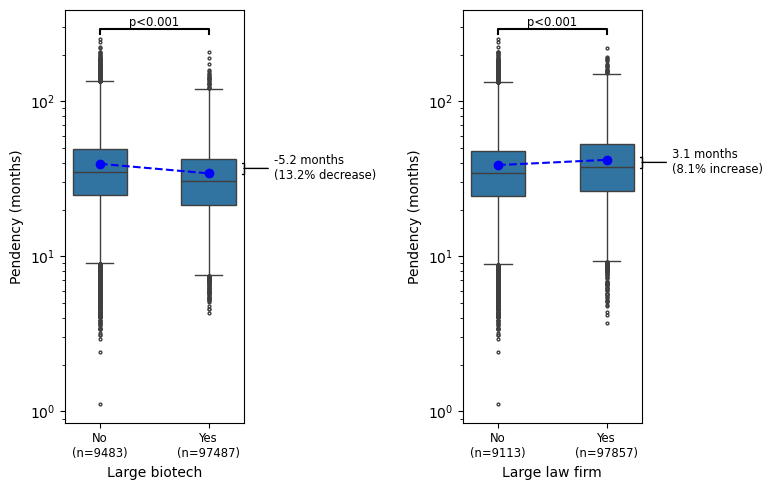

In [332]:
# Initialize figure, subfigs, and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, layout='tight', figsize=(8, 5))

def mean_diff_sig(df_in, var):
    control = np.asarray(df_in[df_in[var] == False]['pendency'])
    treated = np.asarray(df_in[df_in[var] == True]['pendency'])
    # Calculate diff in means
    control_mean = np.mean(control)
    treated_mean = np.mean(treated)
    mean_diff = treated_mean-control_mean
    # Express mean diff as percent of control
    diff_as_percent = mean_diff/control_mean*100
    # Unpaired t-test
    tstat, p = stats.ttest_ind(control, treated)
    return control_mean, treated_mean, mean_diff, diff_as_percent, tstat, p

# Plot the box plots
for var, ax in zip(['large_biotech', 'large_firm'], (ax1, ax2)):
    ax.set_yscale('log')
    sns.boxplot(patex_corres, 
                x=var, y='pendency',
                width=.5, 
                fliersize=2,
                ax=ax)

# Add stats and annotate them
mean_stats = []
for var in ['large_biotech', 'large_firm']:
    cm, tm, md, dp, t, p = mean_diff_sig(patex_corres, var)
    mean_stats.append([cm, tm, md, dp, t, p])
    
for (cm, tm, md, dp, t, p), ax in zip(mean_stats, [ax1, ax2]):
    # Plot line plots showing diff in means
    ax.plot([0, 1], [cm, tm], 'bo--')
    # Add brackets to annotate with some stats 
    x = 1.3
    w = .3
    if md > 0:
        ax.annotate(f"{md:.1f} months\n({abs(dp):.1f}% increase)", 
                    xy=(x, (cm+tm)*.5), xycoords='data', 
                    xytext=(x+w, (cm+tm)*.5), textcoords='data', 
                    va='center', ha='left', 
                    arrowprops=dict(arrowstyle=f"-[, widthB=0.5, angleB=0", 
                                    connectionstyle="arc3"), fontsize='small')
    else:
        ax.annotate(f"{md:.1f} months\n({abs(dp):.1f}% decrease)", 
                    xy=(x, (cm+tm)*.5), xycoords='data', 
                    xytext=(x+w, (cm+tm)*.5), textcoords='data', 
                    va='center', ha='left', 
                    arrowprops=dict(arrowstyle=f"-[, widthB=0.5, angleB=0", 
                                    connectionstyle="arc3"), fontsize='small')
    # Add p-value brackets
    x1, x2 = 0, 1
    y, h = patex_corres['pendency'].max() + 20, 20
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
    if p < 0.001:
        ax.text((x1+x2)*.5, y+h, "p<0.001", 
                ha='center', va='bottom', fontsize='small')
    else:
        ax.text((x1+x2)*.5, y+h, f"{p:.2f}", 
                ha='center', va='bottom', fontsize='small')

# Set labels for xticks, showing n
def n_equals(df_in, var):
    return len(df_in[df_in[var] == True]['pendency']), len(df_in[df_in[var] == False]['pendency'])
ns = [n_equals(patex_corres, 'large_biotech'), n_equals(patex_corres, 'large_firm')]
for nns, ax in zip(ns, (ax1, ax2)):
    xticks = ax.get_xticks()
    ax.set_xticks(xticks, labels=[
        f'No\n(n={nns[0]})', 
        f'Yes\n(n={nns[1]})'], fontsize='small'
)

# Set labels for y- and x-axes
ax1.set_xlabel('Large biotech')
ax2.set_xlabel('Large law firm')
for ax in ax1, ax2:
    ax.set_ylabel('Pendency (months)')
    
plt.show()
fig.savefig('results/biotech-firm-pendency', format='png', dpi=150)

In [83]:
# Find the proportion of apps. filed by large firms
biotech_firm_prop = (patex_corres
                 .groupby('large_biotech')['large_firm']
                 .value_counts(normalize=True)
                 .mul(100)
                 .round(2)
                 .unstack()
)

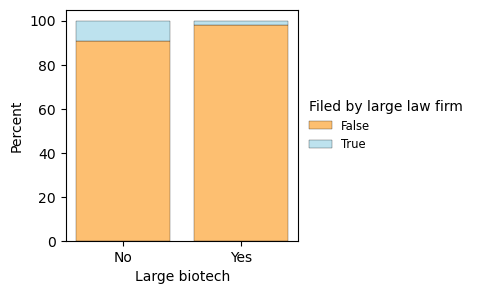

In [335]:
# Initialize figure
fig, ax = plt.subplots(figsize=(3, 3))

# Initialize the bottom at zero for the first set of bars
bottom = np.zeros(len(biotech_firm_prop))

# Hex codes of colors to use for each layer
colors = sns.color_palette('RdYlBu', 2).as_hex()

# Plot each set of bars as a layer, updating the 'bottom' 
# as each layer gets added so that the next bar starts higher
for col, color in zip(biotech_firm_prop.columns, colors):
    ax.bar(x=biotech_firm_prop.index, 
           height=biotech_firm_prop[col], width=0.8,
           label=col, bottom=bottom, color=color, 
           edgecolor='black', lw=0.2)
    bottom += np.array(biotech_firm_prop[col])
    
# Set labels
ax.set_xlabel('Large biotech')
ax.set_xticks([0, 1], labels=['No', 'Yes'])
ax.set_ylabel('Percent')

# Adjust legend position
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small', 
          title='Filed by large law firm', alignment='left', frameon=False)

plt.show()
fig.savefig('results/prop-large-firm', format='png', dpi=150, bbox_inches='tight')

## Patent categories

### Change in types of inventions over time

Question: How do the trends in categories of patent applications being filed change over time?

For this question, we use the `cat_moonshot` dataset.

In [39]:
# Subset `cat_moonshot` to filing dates between 1976 to 2014
cat_moonshot = cat_moonshot.loc[(cat_moonshot['Filing_Date'] > '1976') 
                                & (cat_moonshot['Filing_Date'] < '2015')]

In [40]:
# Group by the filing date, then aggregate the data to express the categories as proportions by filing year
cat_moonshot_prop = (cat_moonshot
                 .groupby(cat_moonshot['Filing_Date'].dt.year)['category']
                 .value_counts(normalize=True)
                 .mul(100)
                 .round(2)
                 .unstack()
                 .fillna(0)
)

In [41]:
# Sort the category columns by which category takes up the largest share in the earliest year
cat_moonshot_prop.sort_values(by=cat_moonshot_prop.index.min(), axis=1, ascending=True, inplace=True)

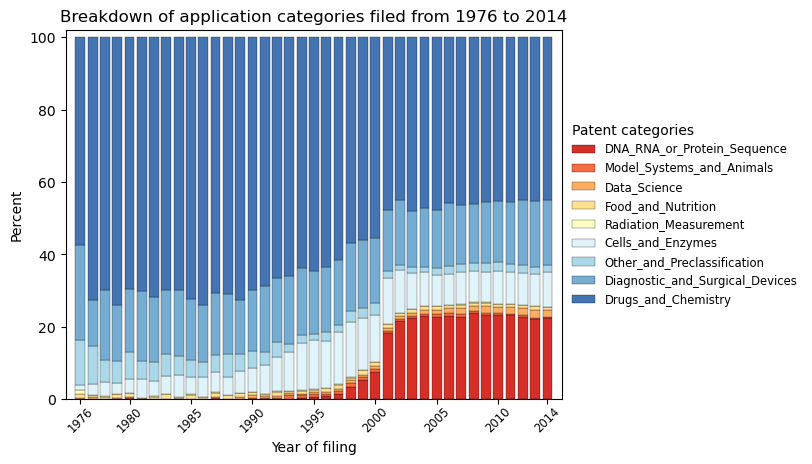

In [120]:
# Initialize figure
fig, ax = plt.subplots()

# Initialize the bottom at zero for the first set of bars
bottom = np.zeros(len(cat_moonshot_prop))

# Hex codes of colors to use for each layer
colors = sns.color_palette('RdYlBu', 9).as_hex()

# Plot each set of bars as a layer, updating the 'bottom' 
# as each layer gets added so that the next bar starts higher
for col, color in zip(cat_moonshot_prop.columns, colors):
    ax.bar(x=cat_moonshot_prop.index, 
           height=cat_moonshot_prop[col], 
           label=col, bottom=bottom, color=color, 
           edgecolor='black', lw=0.2)
    bottom += np.array(cat_moonshot_prop[col])
    
# Set labels
ax.set_xlabel('Year of filing')
ax.set_xticks([1976, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014])
ax.tick_params(axis='x', labelsize='small', rotation=45, pad=0.1)
ax.set_ylabel('Percent')
ax.set_title(f'Breakdown of application categories filed from '
             f'{cat_moonshot_prop.index.min()} to '
             f'{cat_moonshot_prop.index.max()}')

# Adjust legend position
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small', 
          title='Patent categories', alignment='left', frameon=False)

# Adjust margins
ax.margins(0.02,0.02)

plt.show()
fig.savefig('results/prop-categories-by-year', dpi=150, format='png', bbox_inches='tight')

We can also express the category data as absolute values instead of proportions.

In [43]:
# Express data as counts instead of proportions
cat_moonshot_count = (cat_moonshot
                      .groupby(cat_moonshot['Filing_Date'].dt.year)['category']
                      .value_counts()
                      .unstack()
                     )

# Pivot from wide to long format
cat_moonshot_count = cat_moonshot_count.melt(ignore_index=False, value_name='counts').reset_index()

In [44]:
cat_moonshot_count.head()

,Filing_Date,category,counts
0,1976,Cells_and_Enzymes,3.0
1,1977,Cells_and_Enzymes,8.0
2,1978,Cells_and_Enzymes,12.0
3,1979,Cells_and_Enzymes,10.0
4,1980,Cells_and_Enzymes,14.0


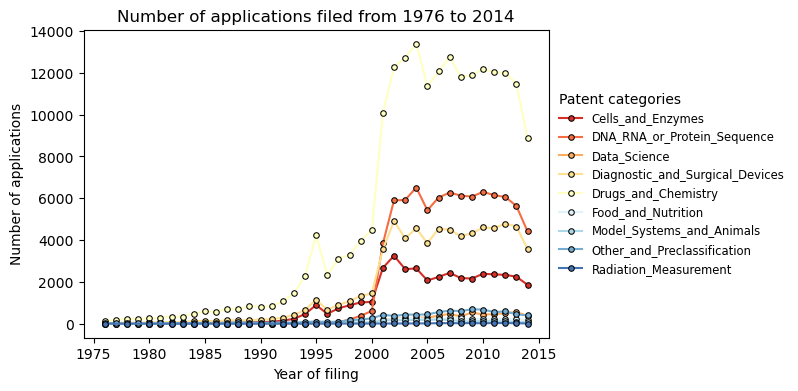

In [121]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot line plot
prop_kwargs = dict(
    palette='RdYlBu', 
    style='category', 
    dashes=False,
    markers=dict(zip(categories, ['o']*len(categories))), 
    markeredgecolor='black', 
    markersize=4
)
sns.lineplot(
    data=cat_moonshot_count, 
    x='Filing_Date', y='counts', 
    hue='category',
    ax=ax, **prop_kwargs
)

# Add labels and legend
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small', 
          title='Patent categories', alignment='left', frameon=False)
ax.set_xlabel('Year of filing')
ax.set_ylabel('Number of applications')
ax.set_title(
    f'Number of applications filed from '
    f'{cat_moonshot_count["Filing_Date"].min()} to '
    f'{cat_moonshot_count["Filing_Date"].max()}'
)

plt.show()
fig.savefig('results/count-categories-by-year', dpi=150, format='png', bbox_inches='tight')

This is not so informative, as the increase in absolute counts here is likely just attributable to the publication of pending applications for the first time in 2000 (see the technical document for more info). Of note, the "surge" of filings in 2000 is likely due to the fact that applicants were trying to file before the implementation of the AIPA in order to avoid pre-grant publication. And again, the slight drop in number of applications from 2014 to 2015 is likely attributable to the pre-grant publication lag.

A more informative approach may be to look at how the proportions filed in each category changes over time. We can go back to our `cat_moonshot_prop` dataset.

In [46]:
def divide_by_baseline(x):
    '''Takes the grouped dataframe and finds a 'baseline year' and
    count of apps for that baseline year. Then divides each value 
    in the 'counts' column by the baseline count to get the fold 
    change in each successive year normalized to the baseline.
    '''
    baseline_year = x[x['counts'].notna()]['Filing_Date'].min()
    baseline_count = x[x['Filing_Date'] == baseline_year]['counts'].values[0]
    x['norm_to_baseline'] = x['counts'] / baseline_count
    return x

In [47]:
# Apply function to get normalized counts to baseline
cat_moonshot_count = cat_moonshot_count.groupby('category', group_keys=False).apply(divide_by_baseline)

In [48]:
# Get counts normalized by the previous year's counts
cat_moonshot_count['norm_to_prev'] = (cat_moonshot_count.groupby('category', group_keys=False)['counts']
                                  .apply(lambda x: x / x.shift())
)

In [49]:
cat_moonshot_count.head()

,Filing_Date,category,counts,norm_to_baseline,norm_to_prev
0,1976,Cells_and_Enzymes,3.0,1.000000,NaN
1,1977,Cells_and_Enzymes,8.0,2.666667,2.666667
2,1978,Cells_and_Enzymes,12.0,4.000000,1.500000
3,1979,Cells_and_Enzymes,10.0,3.333333,0.833333
4,1980,Cells_and_Enzymes,14.0,4.666667,1.400000


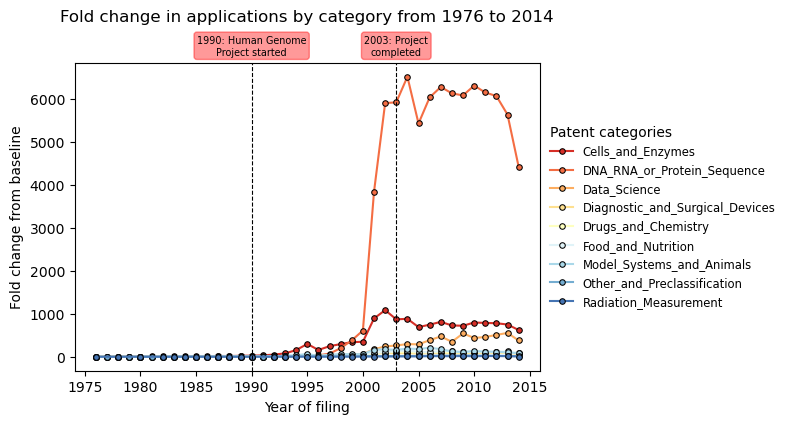

In [123]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Assign the categories to a list for marker assignment
categories = cat_moonshot_count['category'].unique()

# Plot line plot
prop_kwargs = dict(
    palette='RdYlBu', 
    style='category', 
    dashes=False,
    markers=dict(zip(categories, ['o']*len(categories))), 
    markeredgecolor='black', 
    markersize=4
)
sns.lineplot(
    data=cat_moonshot_count, 
    x='Filing_Date', y='norm_to_baseline', 
    hue='category', **prop_kwargs
)

# Add axes labels and legend
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small', 
          title='Patent categories', alignment='left', frameon=False)
ax.set_xlabel('Year of filing')
ax.set_ylabel('Fold change from baseline')
ax.set_title(
    f'Fold change in applications by category from '
    f'{cat_moonshot_count["Filing_Date"].min()} to '
    f'{cat_moonshot_count["Filing_Date"].max()}',
    pad=30
)

# Add vertical line showing year the HGP was completed
ax.axvline(x=1990, ls='dashed', lw=0.8, color='black')
ax.axvline(x=2003, ls='dashed', lw=0.8, color='black')
ax.text(1990, 1.02, s='1990: Human Genome\nProject started', fontsize='x-small', 
        bbox=dict(boxstyle='round', fc='red', ec='red', alpha=0.4), ha='center', va='bottom', 
        transform=ax.get_xaxis_transform())
ax.text(2003, 1.02, s='2003: Project\ncompleted', fontsize='x-small', 
        bbox=dict(boxstyle='round', fc='red', ec='red', alpha=0.4), ha='center', va='bottom', 
        transform=ax.get_xaxis_transform())
# ax.fill_between([1990, 2003], 0, 1, color='lightgray', alpha=0.2, transform=ax.get_xaxis_transform())

plt.show()
fig.savefig('results/fold-change-categories', dpi=150, format='png', bbox_inches='tight')

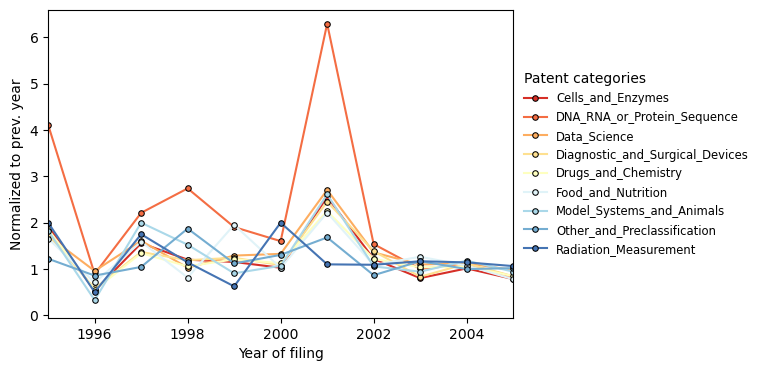

In [127]:
# Get array of categories
categories = cat_moonshot_count['category'].unique()

# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot line plot
sns.lineplot(
    data=cat_moonshot_count, 
    x='Filing_Date', y='norm_to_prev', 
    hue='category', **prop_kwargs
)
# Set xlim to zoom in on the years around 2000
ax.set_xlim(1995, 2005)

# Add axes labels and legend
ax.set_xlabel('Year of filing')
ax.set_ylabel('Normalized to prev. year')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize='small', 
          title='Patent categories', alignment='left', frameon=False)

plt.show()
fig.savefig('results/norm-to-prev-categories', dpi=150, format='png', bbox_inches='tight')

<Axes: xlabel='Filing_Date', ylabel='Proportion'>

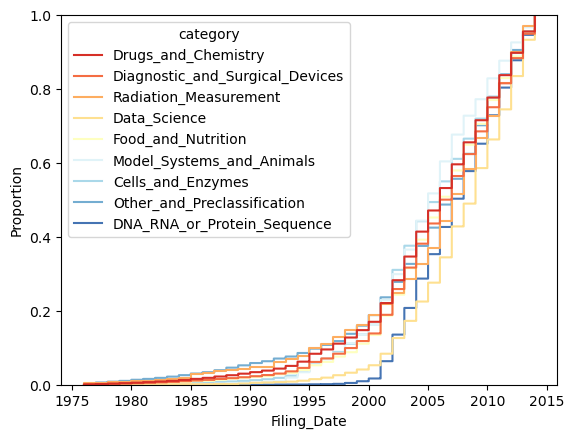

In [52]:
sns.ecdfplot(data=cat_moonshot, x=cat_moonshot["Filing_Date"].dt.year, hue="category", palette='RdYlBu')

### Visualizing the locations of inventors on genomics-based applications

Inventor information is stored in `all_inventors.csv` as part of the PatEx 2022 release. Let's merge it with `cat_moonshot` to link inventor information to the different patent categories.

Some questions for this section:
- How does inventor team size change over time?
- For the first DNA/RNA/protein applications filed in the early 2000s, where were these inventors located? How does this compare to DNA/RNA/protein applications filed in later years?

In [85]:
# Import packages for working with geospatial data
import pandas as pd
import geopandas as gpd
import geoplot as gplt

In [86]:
# Get the list of app numbers
app_numbers = cat_moonshot['Application_Number'].unique()

In [87]:
# Read in all_inventors in chunks and store filtered chunks in a generator called chunks
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/all_inventors.csv', 
                 usecols = ['application_number','inventor_rank','inventor_city_name','inventor_region_code',
                           'inventor_country_code'],
                 chunksize = 10000, iterator=True))

# Create new dataframe by concatenating the individual chunks
patex_inventors = pd.concat(chunks)

In [88]:
patex_inventors.shape

(587035, 5)

In [90]:
# For this part, we don't need inventor rank information, so drop it
# and grab 'category' and 'filing_date' information from 'cat_moonshot'
inventors_loc = (patex_inventors.drop('inventor_rank', axis=1)
            .dropna(axis=0, subset='inventor_city_name')
            .merge(
                cat_moonshot[['Application_Number', 'Filing_Date', 'category']], 
                how='left', left_on='application_number', right_on='Application_Number'
            )
            .drop('Application_Number',axis=1)
            .copy()
)

For simplicity, let's only focus on US-based inventors.

In [91]:
us_inventors = inventors_loc.loc[inventors_loc['inventor_country_code'] == 'US'].copy()

In [92]:
us_inventors.head()

,application_number,inventor_city_name,inventor_region_code,inventor_country_code,Filing_Date,category
83,09403659,CHAPEL HILL,NC,US,2000-02-18,Drugs_and_Chemistry
107,09506906,Encinitas,CA,US,2000-02-18,Drugs_and_Chemistry
108,09506906,Escondido,CA,US,2000-02-18,Drugs_and_Chemistry
109,09506906,San Diego,CA,US,2000-02-18,Drugs_and_Chemistry
110,09506906,Santee,CA,US,2000-02-18,Drugs_and_Chemistry


Notice there are some city names in `us_inventors` that are capitalized. Since this might affect proper merging later on, let's convert all city names to titlecase first.

In [93]:
us_inventors['inventor_city_name'] = us_inventors['inventor_city_name'].str.title()

In one of our earlier graphs, we noticed that there was a big increase in patent applications filed with DNA/RNA/protein sequences going from before 2001 to after 2001. One hypothesis is that this coincides with the completion of the Human Genome Project (abbreviated as HGP) in 2003. <mark>(Are there any papers we could find to show that patent applications generally 'pre-date' a technology?)</mark>

It would make sense to think that these earliest applications are coming from places that were at the forefront of the HGP, or otherwise heavily involved in the development of sequencing technology. Obvious places that come to mind are biomedical hubs in California (e.g., San Diego, San Francisco) and the east coast (NIH, New York, Boston, etc.). If we have location data for inventors on these patent applications, we can visualize where the inventors were located. 

In [94]:
def unique_and_prop(df_in, col='application_number', 
                    groups=['inventor_city_name', 'inventor_region_code']):
    '''This function first groups a dataframe by inventor_city_name and 
    inventor_region_code, then the number of unique applications filed by 
    each city's inventors, as well as that number represented as
    a percent of the total applications.
    '''
    # Get the total number of unique applications
    total = df_in[col].nunique()
    # Group by city name and state and calculate unique apps
    S = df_in.groupby(groups)[col].apply('nunique')
    df_out = pd.DataFrame(S).reset_index().rename(columns={col:'unique_counts'})
    # Calculate the unique apps as a percent of the total
    df_out['prop_of_total'] = df_out['unique_counts']/total * 100
    return df_out

In [95]:
# Since we're comparing pre-2001 to post-2001 applications,
# let's first look at the pre-2001 applications
early_dna = us_inventors[(us_inventors['Filing_Date'].dt.year < 2001) 
                         & (us_inventors['category'].str.contains('DNA'))]

In [96]:
# Generate counts and proportions for 'early_dna'
early_dna_stats = unique_and_prop(early_dna, 
                                  col='application_number',
                                  groups=['inventor_city_name', 'inventor_region_code'])

In [97]:
# Repeat for DNA/RNA apps. filed after 2000
later_dna = us_inventors[(us_inventors['Filing_Date'].dt.year >= 2001) 
                         & (us_inventors['category'].str.contains('DNA'))]

# Generate counts and proportions for 'later_dna'
later_dna_stats = unique_and_prop(later_dna, col='application_number',
                                 groups=['inventor_city_name', 'inventor_region_code'])

Now that we have some data on the locations of US-based inventors and how many patent applications were filed by inventors living in these US cities, we can plot these stats on a map to visualize the data geospatially.

First, we need a shapefile or geoJSON file that has geospatial data for US cities. The one I'm working with is from [here](https://geodata.lib.utexas.edu/catalog/stanford-bx729wr3020). Then, we also need another shapefile that has geospatial data demarcating the boundaries of US states, so that we can map the cities on top of the US states. Luckily, `geoplot` already has a sample dataset that will serve my purpose well.

In [98]:
# Load the shapefile for US cities
usa_cities = gpd.read_file('data/us_cities_2014/citiesx010g.shp')

# Load the sample dataset from geoplot that demarcates state boundaries
# of the contiguous US
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [99]:
usa_cities.head()

,GNIS_ID,ANSICODE,FEATURE,FEATURE2,NAME,POP_2010,COUNTY,COUNTYFIPS,STATE,STATE_FIPS,LATITUDE,LONGITUDE,PopPlLat,PopPlLong,ELEV_IN_M,ELEV_IN_FT,geometry
0,1028750.0,1036000,Civil,-999,Dunseith,773.0,Rolette,079,ND,38,48.813057,-100.060968,48.813057,-100.060968,520.0,1706.0,POINT (-100.06097 48.81306)
1,1030349.0,1036174,Civil,-999,Mylo,20.0,Rolette,079,ND,38,48.635278,-99.618756,48.635278,-99.618756,504.0,1654.0,POINT (-99.61876 48.63528)
2,1027718.0,1035912,Civil,-999,Antler,27.0,Bottineau,009,ND,38,48.970853,-101.282380,48.970853,-101.282380,468.0,1535.0,POINT (-101.28238 48.97085)
3,1028083.0,1035936,Civil,County Seat,Bottineau,2211.0,Bottineau,009,ND,38,48.827230,-100.445698,48.827230,-100.445698,499.0,1637.0,POINT (-100.44570 48.82723)
4,1029080.0,1036050,Civil,-999,Gardena,29.0,Bottineau,009,ND,38,48.700837,-100.497639,48.700837,-100.497639,447.0,1467.0,POINT (-100.49764 48.70084)


The columns we are interested in are `NAME`, `STATE`, and `geometry`. Since we only have the state borders for the contiguous US, we can only keep cities in the continental US.

In [100]:
# Keep only relevant columns and subset to cities in continental US
continental_usa_cities = usa_cities[['NAME','STATE','geometry']].query('STATE not in ["HI", "AK", "PR"]')

In [101]:
continental_usa_cities.sample(5)

,NAME,STATE,geometry
9999,Tonka Bay,MN,POINT (-93.59301 44.90857)
25789,Hiddenite,NC,POINT (-81.09064 35.90374)
33865,Sonestown,PA,POINT (-76.55412 41.35369)
7634,Cedar Vale,KS,POINT (-96.50001 37.10420)
6159,Cowen,WV,POINT (-80.55787 38.40955)


In [102]:
# Merge the cities shapefile with inventor information, joining on city name AND state code
data = [early_dna_stats, later_dna_stats]
merged = []

for df in data:
    merged_df = df.merge(continental_usa_cities, 
                         left_on=['inventor_city_name', 'inventor_region_code'],
                         right_on=['NAME', 'STATE'], how='inner')
    merged.append(merged_df)

In [103]:
# Initialize GeoDataFrames to be able to use geoplot
for i, df in enumerate(merged):
    merged[i] = gpd.GeoDataFrame(df)

In [104]:
# Project 'contiguous_usa' to Albers equal-area conic projection
contiguous_usa = contiguous_usa.to_crs("ESRI:102003")

# Set the cities data to the same CRS to enable layering
for df in merged:
    df = df.to_crs(contiguous_usa.crs, inplace=True)

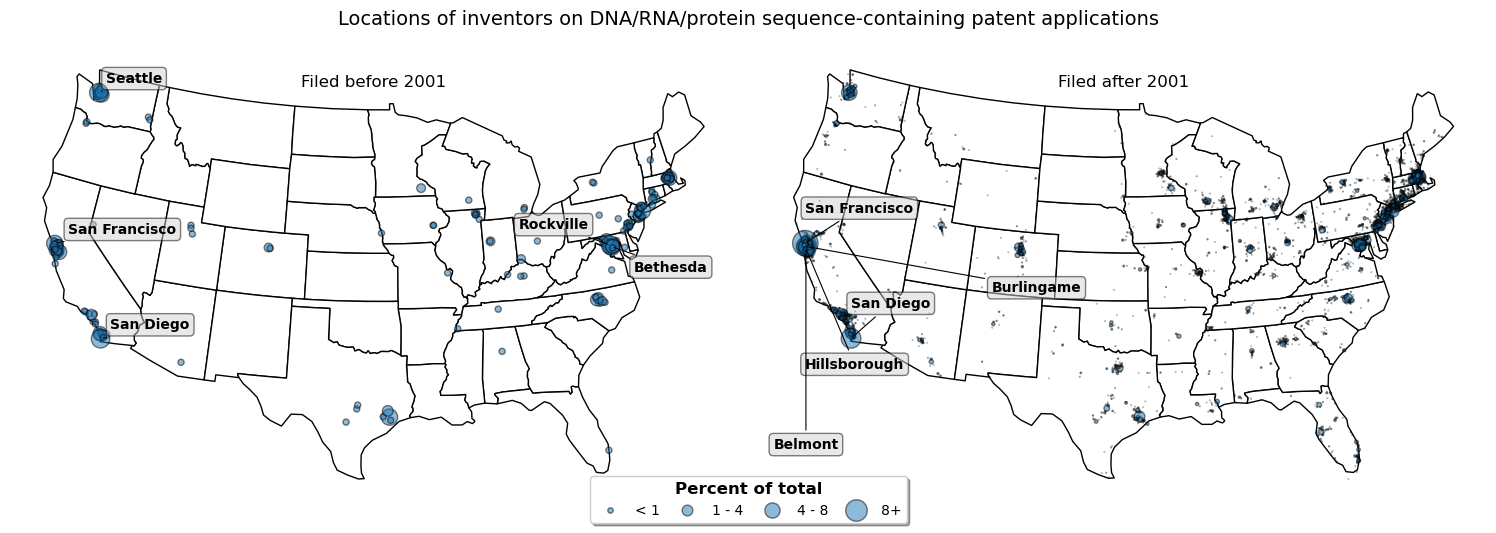

In [339]:
from matplotlib.lines import Line2D
from adjustText import adjust_text

# Set marker sizes
markers = []
for df in merged:
    markers.append(df['prop_of_total']*30)

# Initialize fig and axes
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes(rect=(0, 0, 0.5, 0.9))
ax2 = fig.add_axes(rect=(0.5, 0, 0.5, 0.9))

# Plot outline of US
for ax in ax1, ax2:
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black')

# Plot the cities
for df, marker, ax in zip(merged, markers, [ax1, ax2]):
        df.plot(ax=ax, marker='o', markersize=marker, alpha=0.5, edgecolor='black')

# Remove axis labels
for ax in ax1, ax2:
    ax.set_axis_off()

# The legend is generated not from the data that you see, but from 
# several other layers that are plotted outside the figure (at lat=lon=0).
# This makes it easier to populate the legend box with circles of exact 
# sizes and colors.
legend_elements = [
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(0.5*30), label='< 1', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(2*30), label='1 - 4', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(4*30), label='4 - 8', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(8*30), label='8+', markeredgecolor='black')
]

fig.legend(handles=legend_elements, ncols=4, markerscale=1, shadow=True, 
           fancybox=True, columnspacing=1.0, loc='center', fontsize=10, 
           bbox_to_anchor=(0.5, 0), title="Percent of total", 
           title_fontproperties=dict(weight='semibold', size=12));

# Set subplot titles and fig title
ax1.set_title('Filed before 2001', y=0.9)
ax2.set_title('Filed after 2001', y=0.9)
fig.suptitle('Locations of inventors on DNA/RNA/protein sequence-containing patent applications', 
             fontsize=14)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.01)

# Add label annotations for top 5 cities
top_early = (merged[0]
         .sort_values(by='prop_of_total', ascending=False)
         .head(5)
)
top_later = (merged[1]
         .sort_values(by='prop_of_total', ascending=False)
         .head(5)
)

early_labels = []
for idx, row in top_early.iterrows():
    t = ax1.text(s=row['inventor_city_name'], x=row['geometry'].x, y=row['geometry'].y,
                 fontsize=10, fontweight='semibold', 
                 bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor='black', alpha=0.5))
    early_labels.append(t)

later_labels = []
for idx, row in top_later.iterrows():
    t = ax2.text(s=row['inventor_city_name'], x=row['geometry'].x, y=row['geometry'].y,
                 fontsize=10, fontweight='semibold', 
                 bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor='black', alpha=0.5))
    later_labels.append(t)

# Adjust annotations
adjust_text(early_labels, 
            only_move={'points':'xy', 'text':'xy'}, 
            force_points=5, 
            force_text=5,
            arrowprops=dict(arrowstyle="-", color='black', lw=0.8), 
            ax=ax1)
adjust_text(later_labels, 
            only_move={'points':'y', 'text':'xy'}, 
            force_points=20, 
            force_text=5, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.8), ax=ax2) 

plt.show()
fig.savefig('results/loc-of-inventors', format='png', dpi=150, bbox_inches='tight')

### Change in inventor group sizes over time

In [108]:
inventor_size = patex_inventors.copy()
# Get the inventor group size by finding the max of the inventor_rank for each application
inventor_size = inventor_size.groupby('application_number')[['inventor_rank']].max()

In [109]:
# Merge with 'cat_moonshot' data to get category and filing date info
inventor_size = inventor_size.merge(cat_moonshot, left_on='application_number', right_on='Application_Number')

In [110]:
inventor_size.head()

,inventor_rank,Application_Number,Filing_Date,category
0,1,05652848,1976-01-27,Drugs_and_Chemistry
1,1,05654452,1976-02-02,Drugs_and_Chemistry
2,1,05679431,1976-04-22,Diagnostic_and_Surgical_Devices
3,1,05687505,1976-05-18,Drugs_and_Chemistry
4,1,05696321,1976-06-14,Diagnostic_and_Surgical_Devices


In [111]:
# Get the count and average inventor group size for each filing year
inventor_size_stats = (inventor_size
                     .groupby(inventor_size['Filing_Date'].dt.year)['inventor_rank']
                     .agg(['mean', 'count'])
                     .reset_index()
)

# Get the count and average group size for each category, grouped by filing year
inventor_size_stats_cat = (inventor_size
                     .groupby([inventor_size['Filing_Date'].dt.year, 'category'])['inventor_rank']
                     .agg(['mean', 'count'])
                     .reset_index()
)

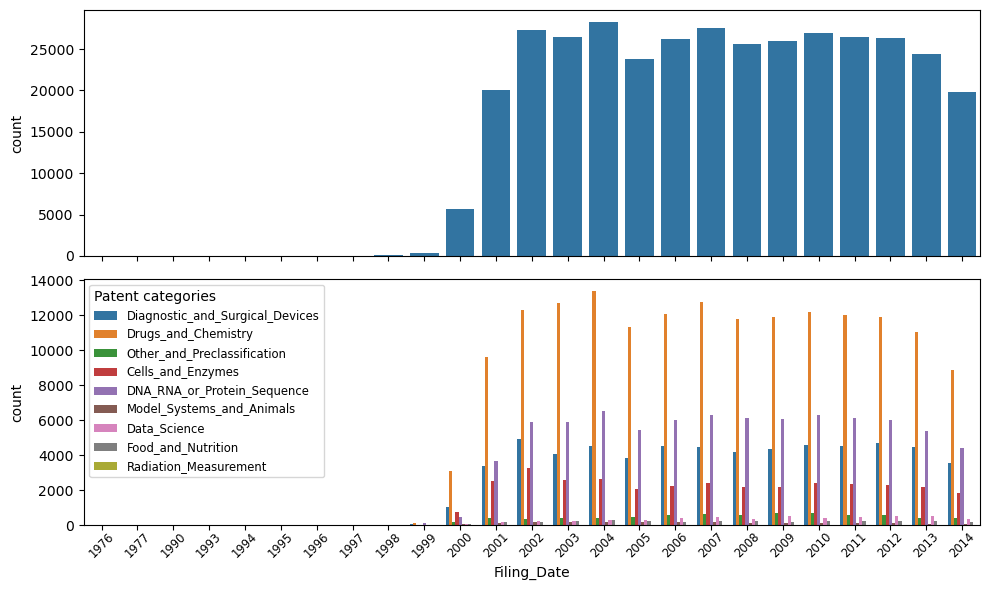

In [112]:
# Initialize fig and axes
fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True, layout='tight')

sns.barplot(data=inventor_size_stats, x='Filing_Date', y='count', ax=axs[0])
sns.barplot(data=inventor_size_stats_cat, x='Filing_Date', y='count', hue='category', ax=axs[1])

# Adjust legend properties
axs[1].legend(title='Patent categories', fontsize='small', alignment='left')

# Adjust positioning of x-axis labels
for ax in axs:
    ax.tick_params(axis='x', labelsize='small', rotation=45, pad=0.1)
    ax.label_outer()

plt.show()

(3.0, 5.0)

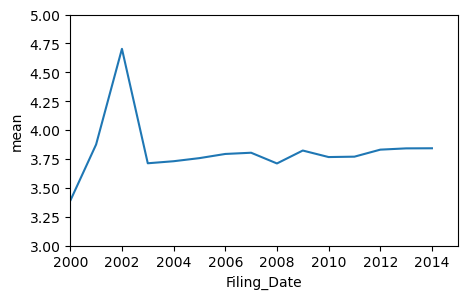

In [113]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(
    data=inventor_size_stats, 
    x='Filing_Date', y='mean', ax=ax)

ax.set_xlim(2000, 2015)
ax.set_ylim(3, 5)

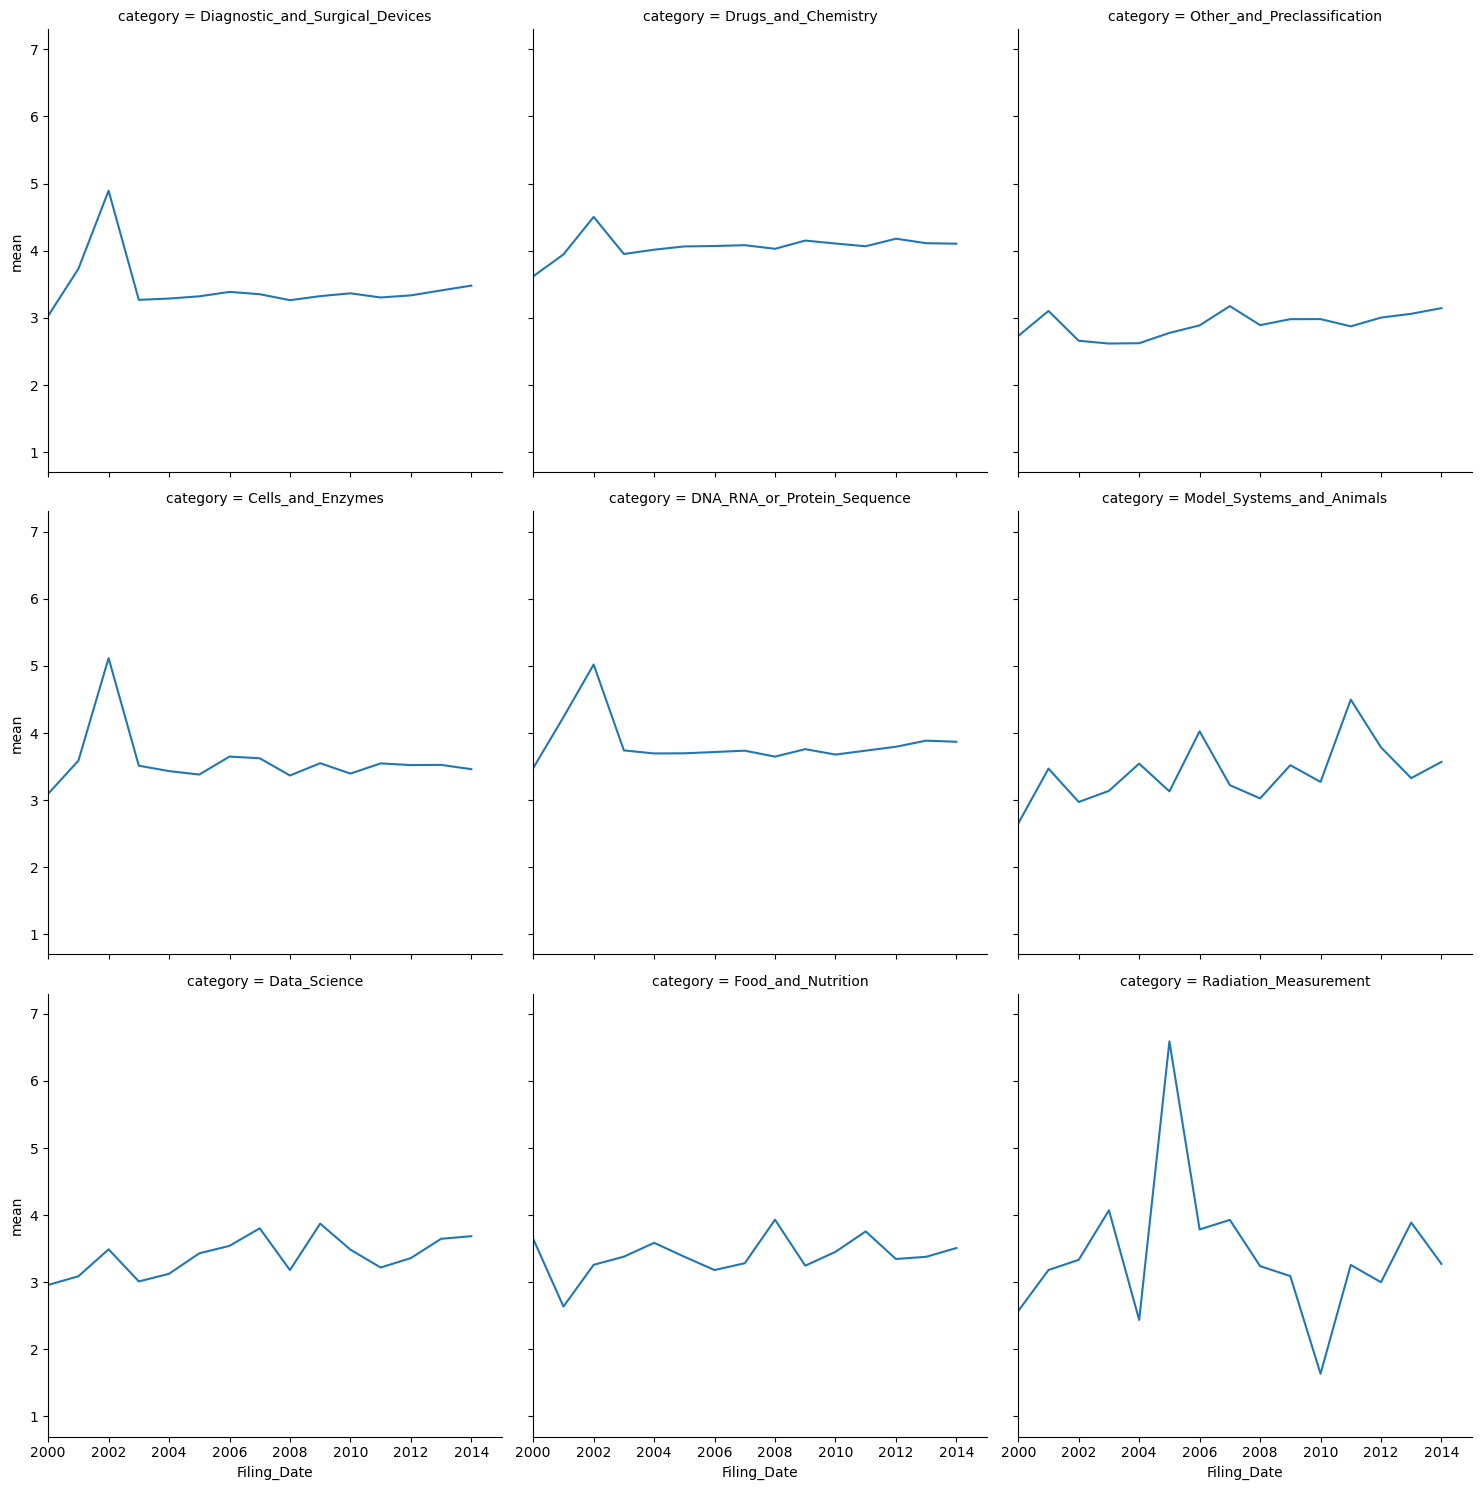

In [114]:
# Plots lineplots of average inventor group size against filing year
# with categories represented on separate facets of the grid
g = sns.relplot(
    data=inventor_size_stats_cat, 
    x='Filing_Date', y='mean', 
    col='category', col_wrap=3, 
    kind='line')
# Set xlim minimum to 2000
g.set(xlim=(2000, 2015))